АВТ-213 Гомзякова Софья

# Лабораторная работа №4

## Введение

### Цель работы

Изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

### Постановка задачи

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

### Описание датасета

Ссылка на датасет: https://www.kaggle.com/datasets/sudhanshu2198/wheat-variety-classification/data

В датасете представлены параметры трех разных сортов пшеницы, по 70 для каждого вида:
- area - Площадь зерна $ A $;
- perimeter - Периметр зерна $ P $;
- compactness - Компактность зерна (выражается как $ \frac{4 \pi A}{P^2} $);
- length - Длина зерна;
- width - Ширина зерна;
- asymmetry coefficient - Коэффициент ассиметрии;
- groove length - Длина колоса;
- category - Сорт пшеницы (три закодированных значения - 0, 1, 2)

Все параметры представляются десятичными числами.

Было решено избавиться от параметров площади зерна и периметра, так как они отражаются в других параметрах (компакность зерна, длина и ширина зерна).

Помимо этого, был удален столбец category, так как он представляет собой класс, к которому относится данное измерение.

## Ход работы

Импорт библиотек:

In [572]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis as kurt, gaussian_kde

Загрузка датасета:

In [573]:
df = pd.read_csv('wheat.csv')
classes = df['category']
df = df.drop(['area', 'perimeter', 'category'], axis=1)

df = df.drop(['length', 'width'], axis=1)

#### Дескриптивный анализ

In [574]:
print('Информация о датасете:')
df.info()
display(df.head())

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compactness            210 non-null    float64
 1   asymmetry coefficient  210 non-null    float64
 2   groove length          210 non-null    float64
dtypes: float64(3)
memory usage: 5.1 KB


,compactness,asymmetry coefficient,groove length
0,0.8710,2.221,5.220
1,0.8811,1.018,4.956
2,0.9050,2.699,4.825
3,0.8955,2.259,4.805
4,0.9034,1.355,5.175


Датасет содержит 210 измерений и 5 столбцов. Все признаки представлены десятичными числами и не имеют пропущенных значений.

Описательный анализ:

In [575]:
display(df.describe())

,compactness,asymmetry coefficient,groove length
count,210.000000,210.000000,210.000000
mean,0.870999,3.700201,5.408071
std,0.023629,1.503557,0.491480
min,0.808100,0.765100,4.519000
25%,0.856900,2.561500,5.045000
50%,0.873450,3.599000,5.223000
75%,0.887775,4.768750,5.877000
max,0.918300,8.456000,6.550000


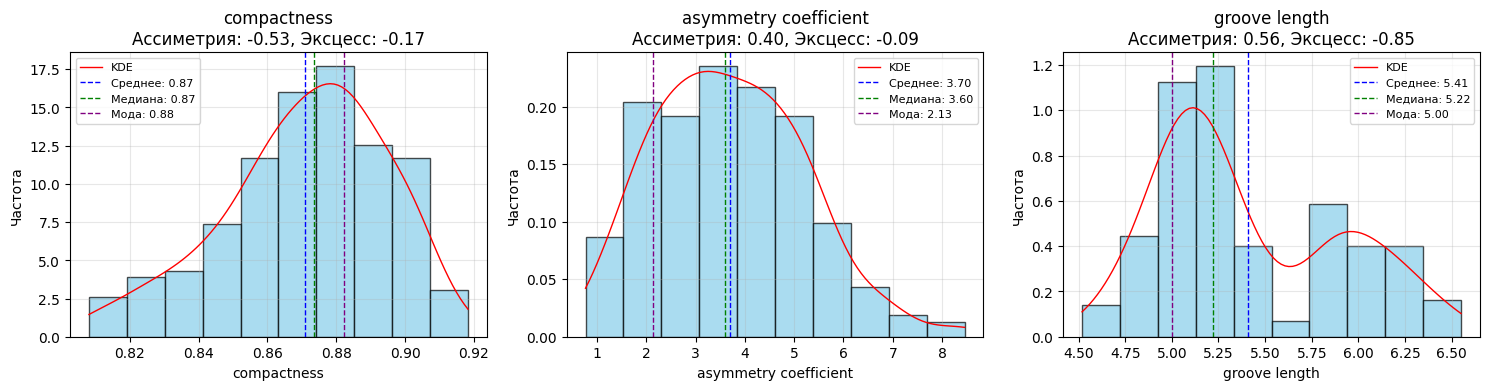

In [576]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if i < len(axes):
        data = df[col]
        axes[i].hist(df[col], edgecolor='black', alpha=0.7, 
                                       color='skyblue', density=True)
        
        mean_val = data.mean()
        median_val = data.median()
        mode_val = data.mode()[0]
        skewness = skew(data)
        kurtosis = kurt(data)
        
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 100)
        kde_curve = kde(x_range)
        axes[i].plot(x_range, kde_curve, 'r-', linewidth=1, label='KDE')
        
        axes[i].axvline(mean_val, color='blue', linestyle='--', linewidth=1, label=f'Среднее: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Медиана: {median_val:.2f}')
        axes[i].axvline(mode_val, color='purple', linestyle='--', linewidth=1, label=f'Мода: {mode_val:.2f}')
        
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')
        axes[i].set_title(f'{col}\nАссиметрия: {skewness:.2f}, Эксцесс: {kurtosis:.2f}')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Из всех признаков compactness ближе всего к нормальному распределению, с приближенно равными средним, медианой и модой, близким к 0 коэффициенту эксцесса и небольшой левосторонней ассиметрией.

length и groove length имеют высокие коэффициенты эксцесса и ассиметрии и разброс между средним, медианой и модой. 

width и asymetry coefficient имеют небольшие показатели эксцесса и ассиметрии и близкие значения среднего и медианы, однако также имеют сильно смещенную моду.

"Ящики с усами" для признаков:

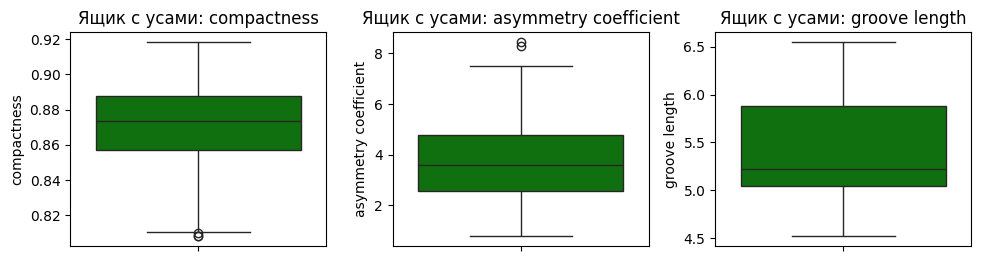

In [577]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df[col], ax=axes[i], color='green')
    axes[i].set_title(f'Ящик с усами: {col}')

for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

По графикам "ящиков с усами" есть небольшие выбросы у compactness и asymmetry coefficient в первом и последнем квартилях соответственно. У остальных признаков все измерения укладываются в 1.5 IQR.

### Предобработка данных

Стандартизация используется, когда признаки имеют разный масштаб данных и когда используются методы, основанные на нормальном распределении или на расстоянии между измерениями / дисперсии, такие как K-Means. Также она сохраняет распределение данных.

Нормализация используется для алгоритмов, требующих определенный диапазон значений или перевод данных в другой диапазон, а также чувствительна к выбросам.

Для признаков из данного датасета больше подходит стандартизация.

In [578]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
y = df.columns

df_scaled = pd.DataFrame(X_scaled, columns=y)

display(df_scaled.describe().round(3))
display(df_scaled.head())

,compactness,asymmetry coefficient,groove length
count,210.000,210.000,210.000
mean,0.000,-0.000,-0.000
std,1.002,1.002,1.002
min,-2.668,-1.957,-1.813
25%,-0.598,-0.759,-0.740
50%,0.104,-0.067,-0.377
75%,0.712,0.712,0.956
max,2.007,3.171,2.329


,compactness,asymmetry coefficient,groove length
0,0.000061,-0.986152,-0.383577
1,0.428515,-1.788166,-0.922013
2,1.442383,-0.667479,-1.189192
3,1.039381,-0.960818,-1.229983
4,1.374509,-1.563495,-0.475356


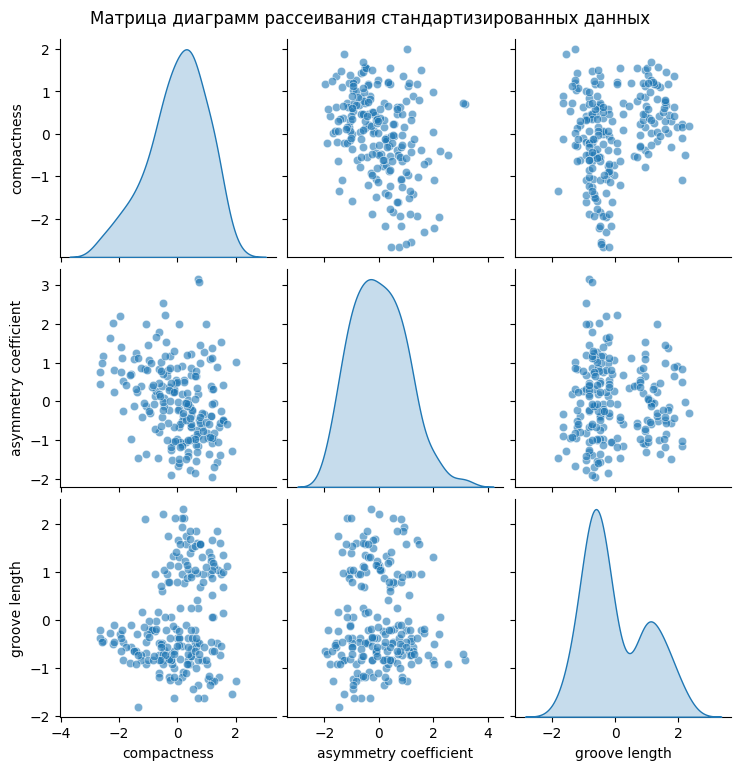

In [579]:
sns.pairplot(df_scaled, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Матрица диаграмм рассеивания стандартизированных данных', y=1.02)
plt.show()

На матрице диаграмм рассеивания можно четко наблюдать 2 кластерные структуры. Самые четкие разделения кластеров наблюдаются по groove length (кластеры более вытянутые и отдаленные), менее четко - по length (кластеры менее сгруппированны и более связанные между собой).

Предположительно в данном датасете можно выделить 2-3 кластера.

Также на диаграммах можно наблюдать корреляцию между groove length и length и width, а также width и compactness и length. Корреляция может негативно повлиять на результаты кластеризации.

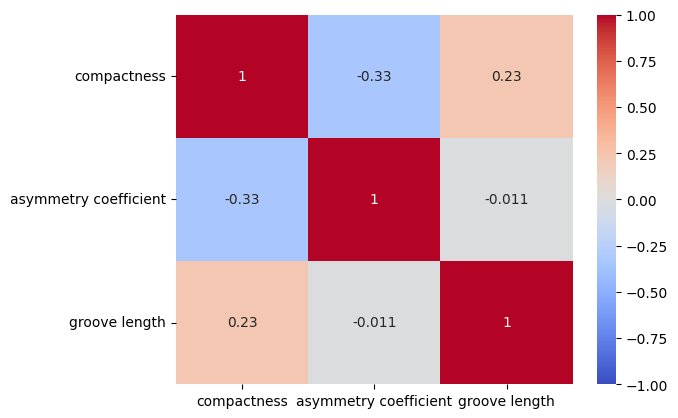

In [580]:
hm = sns.heatmap(df_scaled.corr(), cmap='coolwarm', vmax=1, vmin=-1, annot=True)

Кластеры данных довольно крупные и сгруппированные. По диаграммам рассеивания они округлой формы либо имеют высокую плотность, поэтому для решения задачи кластеризации были выбраны методы K-Means и DBSCAN.

### Кластеризация

#### K-Means

K-means (K-средних) — это алгоритм кластеризации, который разбивает набор данных на K отдельных непересекающихся групп (кластеров). Разбиение на кластеры происходит минимизацией дисперсии внутри кластеров (минимизацией расстояния между точками кластера и центроидом).

Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. Число кластеров известно заранее.

1. Начальные значения центроидов выбираются либо случайно, либо с помощью более продвинутых методов.
2. Каждая точка определяется в кластер на основании того, расстояние до центроида какого кластера минимально.
3. Новый центроид - среднее арифметическое положений всех точек кластера
4. Шаги 2-3 повторяются, пока центроиды не перестанут изменяться.

Подбор оптимального количества кластеров для метода K-Means:

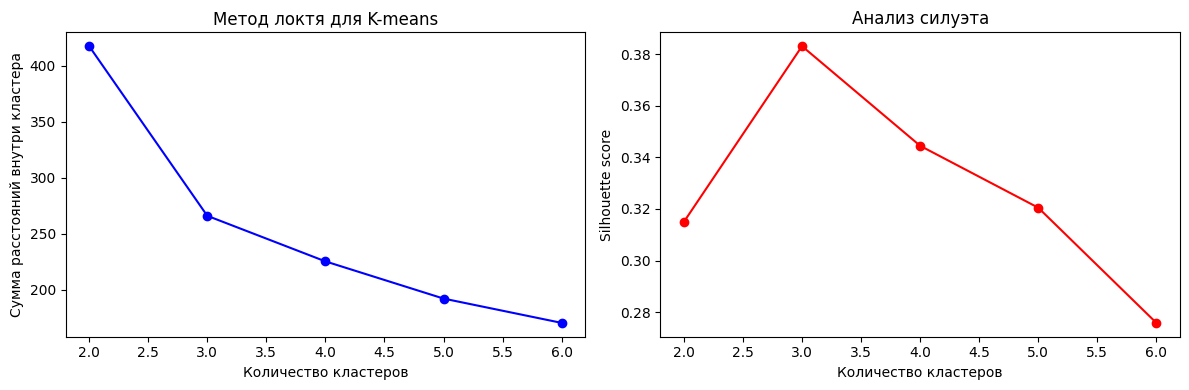

In [581]:
inertia = []
silhouette_scores = []
k_range = range(2, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Сумма расстояний внутри кластера')
ax1.set_title('Метод локтя для K-means')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Анализ силуэта')

plt.tight_layout()
plt.show()

Для метода локтя оптимальное количество кластеров 3, для силуэтов - 2. Для дальнейшей работы выбрано значение в 3 кластера.

Применение алгоритма K-Means для 3 кластеров:

In [582]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

def evaluate_clustering(X, labels, method_name):
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    print(f"{method_name}:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Индекс Калински–Харабаша: {calinski:.3f}")
        
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            within_dist = np.mean(np.linalg.norm(cluster_points - cluster_points.mean(axis=0), axis=1))
            print(f"Кластер {label}: {len(cluster_points)} точек, среднее расстояние: {within_dist:.3f}")

evaluate_clustering(X_scaled, kmeans_labels, "K-means")

print("\nЦентры кластеров K-means (стандартизированные):")
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, 
                         columns=df_scaled.columns)
print(centers_df)

K-means:
Silhouette Score: 0.383
Индекс Калински–Харабаша: 141.533
Кластер 0: 70 точек, среднее расстояние: 1.043
Кластер 1: 70 точек, среднее расстояние: 1.079
Кластер 2: 70 точек, среднее расстояние: 0.957

Центры кластеров K-means (стандартизированные):
   compactness  asymmetry coefficient  groove length
0     0.882821               3.642157       6.032343
1     0.847963               4.946571       5.137729
2     0.882211               2.511874       5.054143


Было выделено 3 кластера по 68-71 точки с оценкой методом силуэта 0.395 и индексом Калински-Харабаша 196.547.

Визуализация кластеров:

Объясненная дисперсия PCA: [0.46895529 0.32989136 0.20115336]
Суммарная объясненная дисперсия 1.0000


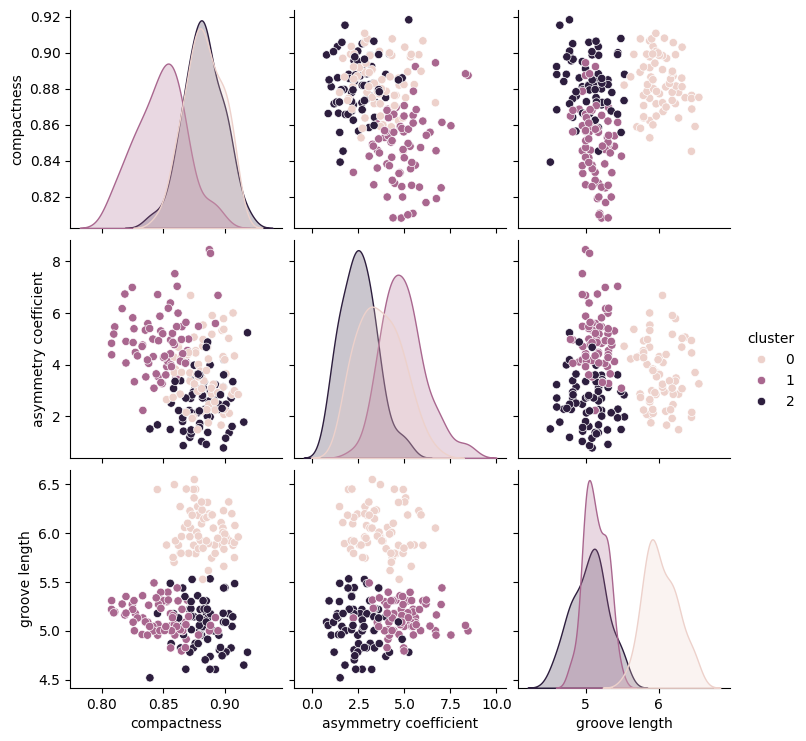

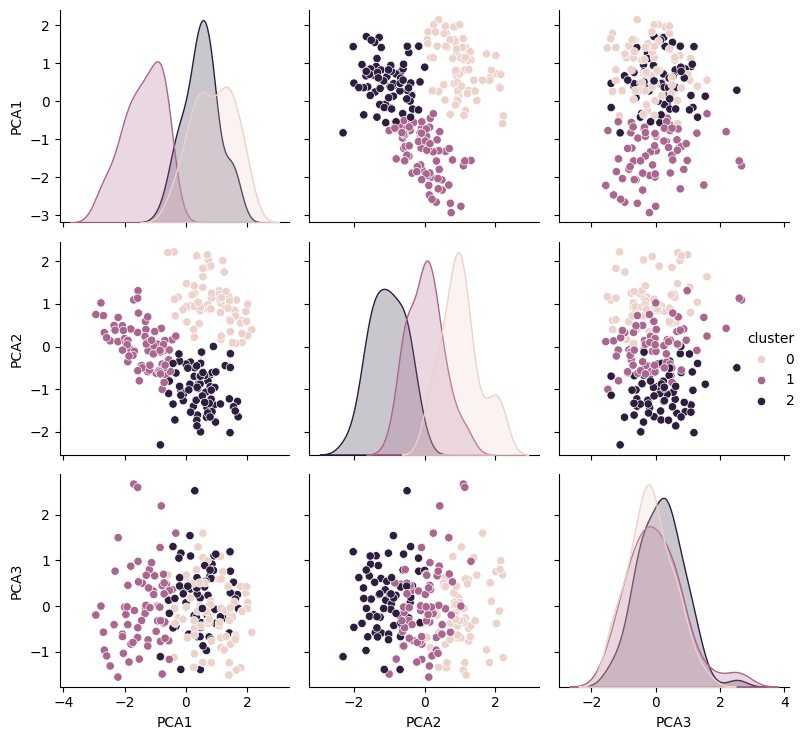

In [583]:
df_labels = df.copy()
df_labels = df_labels.assign(cluster=kmeans_labels)
sns.pairplot(df_labels, hue='cluster')

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

cols = [f'PCA{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(data=X_pca, columns=cols)
df_pca = df_pca.assign(cluster=kmeans_labels)

df_pca.head()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_}")
print(f'Суммарная объясненная дисперсия {sum(pca.explained_variance_ratio_):.4f}')

sns.pairplot(df_pca, hue='cluster')

plt.tight_layout()
plt.show()

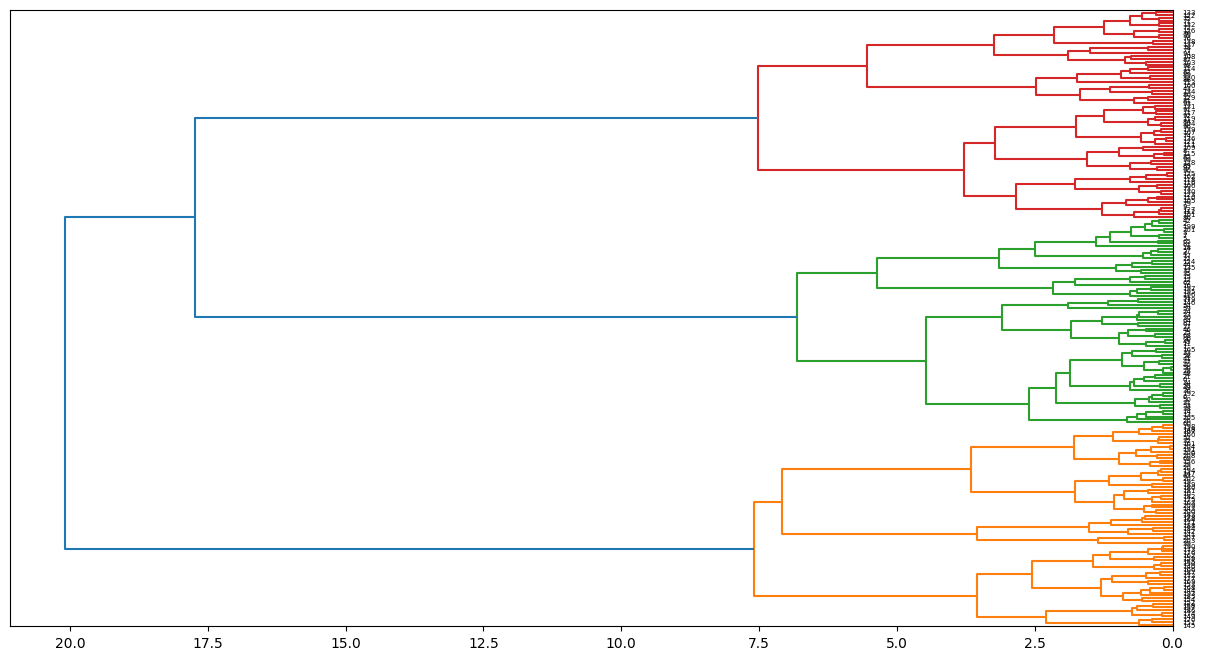

In [584]:
# Пример реализации
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Агломеративная кластеризация
hc = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
tree_labels = hc.fit_predict(X_scaled)

# Дендрограмма
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(15,8))
ax = plt.subplot(1, 1, 1)
r = dendrogram(Z, orientation='left', ax=ax)

In [585]:
evaluate_clustering(X_scaled, tree_labels, "Иерархическая кластеризация")

Иерархическая кластеризация:
Silhouette Score: 0.376
Индекс Калински–Харабаша: 136.947
Кластер 0: 69 точек, среднее расстояние: 1.054
Кластер 1: 71 точек, среднее расстояние: 1.049
Кластер 2: 70 точек, среднее расстояние: 0.998


Объясненная дисперсия PCA: [0.46895529 0.32989136 0.20115336]
Суммарная объясненная дисперсия 1.0000


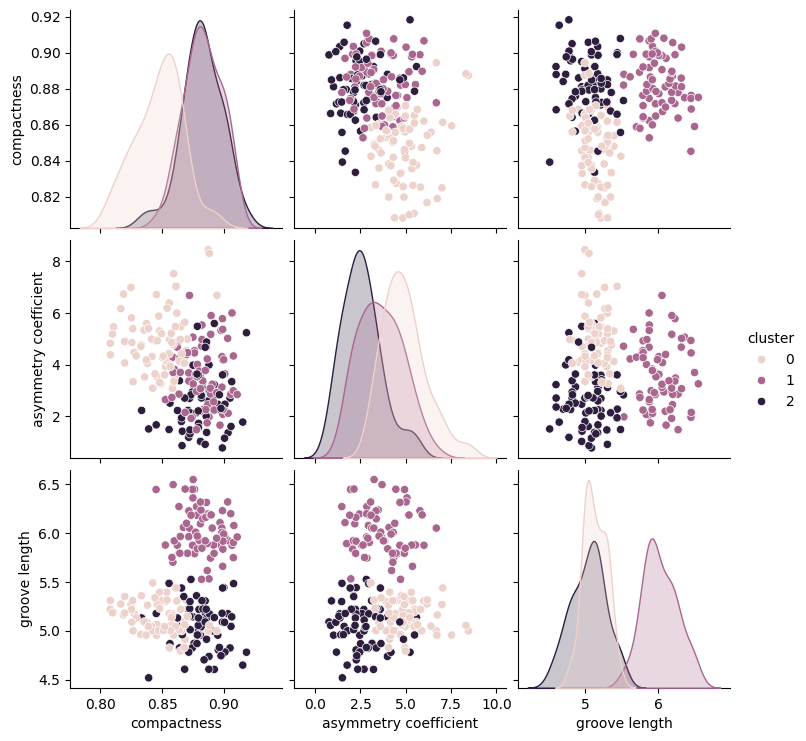

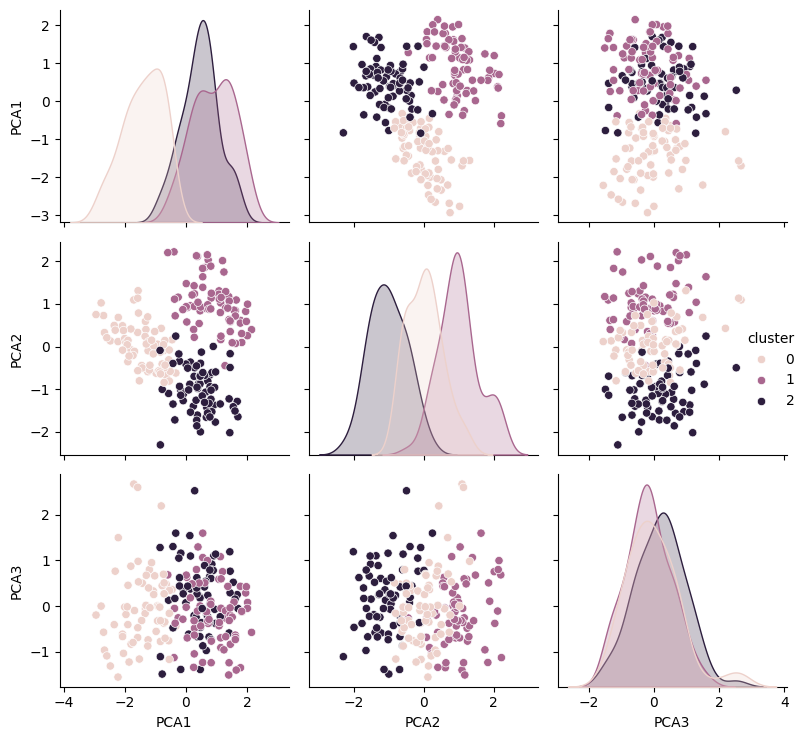

In [586]:
df_labels = df.copy()
df_labels = df_labels.assign(cluster=tree_labels)
sns.pairplot(df_labels, hue='cluster')

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

cols = [f'PCA{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(data=X_pca, columns=cols)
df_pca = df_pca.assign(cluster=tree_labels)

df_pca.head()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_}")
print(f'Суммарная объясненная дисперсия {sum(pca.explained_variance_ratio_):.4f}')

sns.pairplot(df_pca, hue='cluster')

plt.tight_layout()
plt.show()